<table border="0" width="100%"><p align="left"><img src="logo.png"  align="left" width=30%></table>

# <center>Chapter 4 词嵌入与word2vec</center>

**在前面几章中，我们已经学习了创建单词向量表示的传统方法，比如one-hot，词典。向量的长度都与词的个数有关，一般来说，文本越长，就需要用越长的向量来表示。有没有可能用一个低维的密集向量来表示长文本呢，这就是本章节的主要内容。**
###  本章节基本组织如下:
* 什么是词嵌入
* word2vec方法（纯python与调包）
* 利用PCA方法对词嵌入向量降至二维并可视化

## 1.什么是词嵌入

**词嵌入：指把一个维数为所有词的数量的高维空间嵌入到一个维数低得多的连续向量空间中**
<img src="词嵌入图1.jpg" width=60%>
**可以用一个简单的方法实现——矩阵乘法:假设one-hot向量长度为N，只需要与一个N*n的权重矩阵相乘，就可以降维为一个n维的低维向量**
<img src="词嵌入图片2.png" width=60%>

In [28]:
import numpy as np
weight_matrix = np.random.rand(10, 2)  #生成符合服从“0-1”分布的随机权重矩阵(10*2)
print(weight_matrix)

[[0.01988013 0.02621099]
 [0.02830649 0.24621107]
 [0.86002795 0.53883106]
 [0.55282198 0.84203089]
 [0.12417332 0.27918368]
 [0.58575927 0.96959575]
 [0.56103022 0.01864729]
 [0.80063267 0.23297427]
 [0.8071052  0.38786064]
 [0.86354185 0.74712164]]


In [29]:
one_hot = [1,0,0,1,0,1,1,1,0,0]  # 1*10维one_hot文本向量（高维）
print(np.dot(one_hot,weight_matrix))   #低维表示

[2.52012428 2.08945919]


**在这里，权重矩阵是随机初始化的，得到的嵌入向量自然是毫无意义的，假如我们以某种方式通过训练得到了一个权重矩阵，可以捕获到嵌入向量之间的语法与语义关系，例如：**
<img src="词嵌入图2.jpg" width=40%>
**而进一步扩展，神经网络模型也就是一个个节点相连的矩阵运算，word2vec，bert，GPT等等模型都是通过构造某种显式或隐式的辅助训练方法与特殊结构来捕获文本语料库语言属性的一个权重矩阵，而词嵌入，就可以理解为基于某种方法得到一个模型，利用该模型将稀疏的文本向量表示为富含语义的密集向量**

## 2.word2vec

 **Word2Vec是一种简单并且计算高效的学习词嵌入的算法。Word2Vec的核心思想是学习一个神经网络语言模型来训练词向量，能够这些单词之间的关系。它基于分布式假设：上下文相似的词，其词嵌入向量也是相似的。word2vec使用推理的方法完成词嵌入
 <img src="https://pic2.zhimg.com/80/v2-28b59815b82157fecdd08bf88bce53a1_720w.jpg" width=70%>
word2vec分为两种模型：**
* skip-gram：
用当前词来预测上下文。相当于给你一个词，让你猜前面和后面可能出现什么词。
* CBOW，continuous bag of words：
通过上下文来预测当前值。相当于一句话中扣掉一个词，让你猜这个词是什么。
<img src="https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic4.zhimg.com%2Fv2-e7bcb17222fbcf730e59c7fcfa2071e5_1200x500.jpg&refer=http%3A%2F%2Fpic4.zhimg.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1664211820&t=eedd810083f38ed9bb83f55172042878" width=70%>

### (1).纯python方法实现word2vec CBOW

**把神经网络模型想象成搭积木，首先我们要定义全连接层（矩阵相乘）：**

In [30]:
class MatMul:    #创建矩阵乘积的类，本质上就是np.dot，只不过加入了神经网络的反向传播
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):  #正向传播
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):   #反向传播
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW   #设置梯度权重
        return dx

In [31]:
one_hot = [1,0,0,1,0,1,1,1,0,0]  # 1*10维one_hot文本向量（高维）
weight_matrix = np.random.rand(10, 2)  #生成符合服从“0-1”分布的随机权重矩阵(10*2)
layer = MatMul(weight_matrix)   #创建全连接层
print(layer.forward(one_hot))   #前向传播，也就是np.dot

[1.67435006 2.76383962]


**通过全连接层完成CBOW的推理：**

In [33]:
# 假设我们的文本为“我 爱 你 中 国”
c0 = np.array([[1, 0, 0, 0, 0]])   #c0代表“我”的onehot表示
c2 = np.array([[0, 0, 1, 0, 0]])   #c2代表“你”的onehot表示

# 初始化权重
W_in = np.random.randn(5, 3)    #矩阵乘法规则：输入维度=输出维度
W_out = np.random.randn(3, 5)

# 生成层
in_layer0 = MatMul(W_in)     
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 正向传播
h0 = in_layer0.forward(c0)   #c0通过全连接后得到的向量
h2 = in_layer1.forward(c2)   #c1通过全连接后得到的向量
h = 0.5 * (h0 + h2)          #相加取平均
s = out_layer.forward(h)
print(s)             #得到1*5向量，即我们想要去预测“我”和“你”之间应该是“爱”这个字的预测得分

[[-0.24402117 -1.28061364  0.20446905  0.30276983 -0.46853567]]


**本质上预测中间的单词是一个在语料库上的多分类问题，因此得到预测得分后应该利用softmax函数将其转化为概率，在利用交叉熵计算loss：**

In [37]:
def softmax(x):     #softmax
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):    #交叉熵
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 在监督标签为one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [41]:
x = softmax(s)
y = np.array([[0, 1,0, 0, 0]])   #c1代表“爱”的onehot表示，也就是我们最终想得到的真实值y，即label
loss = cross_entropy_error(x, y)
print(f"预测值: {x}")
print(f"真实值: {y}")
print(f"loss: {loss}")

预测值: [[0.18358018 0.06510876 0.28747667 0.31717146 0.14666294]]
真实值: [[0 1 0 0 0]]
loss: 2.73169471409389


**我们已经实现了CBOW的基本推理结构，现在只需要加入反向传播和梯度下降就可以实现模型的学习，在这之前先把刚才用到的代码打包成类，方便调用，并加入梯度下降优化器，文本处理，模型训练等亿点点细节（可跳过）：**

In [80]:
import time
import matplotlib.pyplot as plt

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 生成层
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax的输出
        self.t = None  # 监督标签

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 在监督标签为one-hot向量的情况下，转换为正确解标签的索引
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx
    
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

    
class Trainer:   #模型训练类，可以跳过
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 打乱
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 计算梯度，更新参数
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 将共享的权重整合为1个
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 评价
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # mini-batch的各笔样本数据的开始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 计算梯度，更新参数
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 将共享的权重整合为1个
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 评价困惑度
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    将参数列表中重复的权重整合为1个，
    加上与该权重对应的梯度
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 在共享权重的情况下
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 加上梯度
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 在作为转置矩阵共享权重的情况下（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

**训练我们自己的CBOW：**

In [84]:
#文本处理
text = '我 爱 你 中 国'

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

corpus, word_to_id, id_to_word = preprocess(text)
print(f"向量表示: {corpus}")
print(f"字典: {id_to_word}")

向量表示: [0 1 2 3 4]
字典: {0: '我', 1: '爱', 2: '你', 3: '中', 4: '国'}


In [82]:
# 生成训练数据X,Y
def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示
    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def create_contexts_target(corpus, window_size=1):
    '''生成上下文和目标词
    :param corpus: 语料库（单词ID列表）
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

window_size = 1
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(f"X: {contexts}")
print(f"Y: {target}")

X: [[[1 0 0 0 0]
  [0 0 1 0 0]]

 [[0 1 0 0 0]
  [0 0 0 1 0]]

 [[0 0 1 0 0]
  [0 0 0 0 1]]]
Y: [[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


| epoch 1 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 2 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 3 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 4 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 5 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 6 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 7 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 8 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 9 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 10 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 11 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 12 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 13 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 14 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 15 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 16 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 17 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 18 |  iter 1 / 3 | time 0[s] | loss 1.61
| epoch 19 |  iter 1 / 3 | time 0[s] | loss 1.60
| epoch 20 |  iter 1 / 3 | time 0[s] | loss 1.60
| epoch 21 |  iter 1 / 3 | ti

| epoch 288 |  iter 1 / 3 | time 0[s] | loss 0.65
| epoch 289 |  iter 1 / 3 | time 0[s] | loss 0.61
| epoch 290 |  iter 1 / 3 | time 0[s] | loss 0.58
| epoch 291 |  iter 1 / 3 | time 0[s] | loss 0.49
| epoch 292 |  iter 1 / 3 | time 0[s] | loss 0.57
| epoch 293 |  iter 1 / 3 | time 0[s] | loss 0.63
| epoch 294 |  iter 1 / 3 | time 0[s] | loss 0.57
| epoch 295 |  iter 1 / 3 | time 0[s] | loss 0.59
| epoch 296 |  iter 1 / 3 | time 0[s] | loss 0.56
| epoch 297 |  iter 1 / 3 | time 0[s] | loss 0.56
| epoch 298 |  iter 1 / 3 | time 0[s] | loss 0.53
| epoch 299 |  iter 1 / 3 | time 0[s] | loss 0.55
| epoch 300 |  iter 1 / 3 | time 0[s] | loss 0.57
| epoch 301 |  iter 1 / 3 | time 0[s] | loss 0.52
| epoch 302 |  iter 1 / 3 | time 0[s] | loss 0.56
| epoch 303 |  iter 1 / 3 | time 0[s] | loss 0.54
| epoch 304 |  iter 1 / 3 | time 0[s] | loss 0.45
| epoch 305 |  iter 1 / 3 | time 0[s] | loss 0.53
| epoch 306 |  iter 1 / 3 | time 0[s] | loss 0.59
| epoch 307 |  iter 1 / 3 | time 0[s] | loss 0.53


| epoch 594 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 595 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 596 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 597 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 598 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 599 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 600 |  iter 1 / 3 | time 0[s] | loss 0.09
| epoch 601 |  iter 1 / 3 | time 0[s] | loss 0.12
| epoch 602 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 603 |  iter 1 / 3 | time 0[s] | loss 0.09
| epoch 604 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 605 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 606 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 607 |  iter 1 / 3 | time 0[s] | loss 0.09
| epoch 608 |  iter 1 / 3 | time 0[s] | loss 0.11
| epoch 609 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 610 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 611 |  iter 1 / 3 | time 0[s] | loss 0.10
| epoch 612 |  iter 1 / 3 | time 0[s] | loss 0.09
| epoch 613 |  iter 1 / 3 | time 0[s] | loss 0.10


| epoch 904 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 905 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 906 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 907 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 908 |  iter 1 / 3 | time 0[s] | loss 0.04
| epoch 909 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 910 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 911 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 912 |  iter 1 / 3 | time 0[s] | loss 0.04
| epoch 913 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 914 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 915 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 916 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 917 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 918 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 919 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 920 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 921 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 922 |  iter 1 / 3 | time 0[s] | loss 0.03
| epoch 923 |  iter 1 / 3 | time 0[s] | loss 0.03


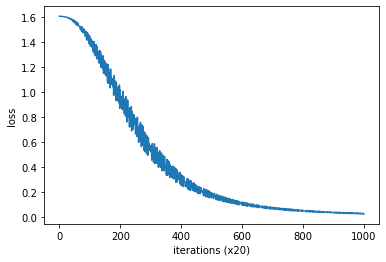

In [83]:
# 模型训练 
hidden_size = 3
batch_size = 1
max_epoch = 1000
model = SimpleCBOW(vocab_size, hidden_size)   #SimpleCBOW模型
optimizer = Adam()                          #优化器设置为Adam
trainer = Trainer(model, optimizer)      #模型训练主体

trainer.fit(contexts, target, max_epoch, batch_size)   #开始训练
trainer.plot()   #画出loss图

In [85]:
# 得到词嵌入向量 
word_vecs = model.word_vecs #保存的地方
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

我 [-1.475043   1.4098275 -1.462503 ]
爱 [-1.1512601 -1.3358028 -1.1459126]
你 [0.18974927 1.8748579  0.14052632]
中 [-1.1669254 -1.3430164 -1.139884 ]
国 [1.4321997 1.2569406 1.4441128]


**我们得到了词嵌入向量，当然，这里使用的一句话语料库太小了，换成更大的语料库，会获得更好的结果。在实际应用中，我们通常会直接方便快速的调用已经训练好的词嵌入模型来完成我们的任务**

### (2).调用word2vec模型完成词嵌入

In [88]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import jieba
import numpy as np
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**读取金融词汇txt文件并分词**

In [104]:
with open("EE.txt", "r",encoding='utf-8') as f:  # 打开文件
    data = f.read()  # 读取文件
    #print(data)
word_list = jieba.cut(data)
result = ' '.join(word_list)
result_s = result.split(' ')
result_s = [result_s]
print(result_s[0][5:20])    #这里没有去除标点符号等停用词，达到更好效果可参照第二章jieba分词来去除停用词

['涨停', '股', '', '', '免费', '下载', '', '', '证券时报', '网', '03', '月', '03', '日讯', '']


**调用并训练gensim自带的word2vec模型**

In [105]:
model = Word2Vec(result_s, min_count=1)

2022-08-28 03:11:11,140 : INFO : collecting all words and their counts
2022-08-28 03:11:11,140 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-28 03:11:11,147 : INFO : collected 5126 word types from a corpus of 31069 raw words and 1 sentences
2022-08-28 03:11:11,148 : INFO : Creating a fresh vocabulary
2022-08-28 03:11:11,169 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 5126 unique words (100.00% of original 5126, drops 0)', 'datetime': '2022-08-28T03:11:11.169045', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-08-28 03:11:11,170 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 31069 word corpus (100.00% of original 31069, drops 0)', 'datetime': '2022-08-28T03:11:11.170046', 'gensim': '4.2.0', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platf

In [114]:
print(f"涨停的词向量: {model.wv['涨停']}")
print(f"与知识产权最接近的6个词: {model.wv.most_similar('知识产权', topn=6)}")

涨停的词向量: [ 0.00022708  0.01069314 -0.00287368 -0.00671757  0.00764089 -0.00031531
  0.01029458  0.01083129 -0.01368472  0.00317339 -0.00060533  0.00335896
  0.0057543   0.00392208 -0.00396685  0.00044373  0.00832523  0.0119933
  0.00302975  0.00085786  0.00201147  0.00549124  0.0112002  -0.01024245
 -0.00375853 -0.0057714   0.00407451 -0.0044203  -0.00936153 -0.00656092
  0.00082509 -0.00287329 -0.01142543 -0.00212646  0.00931283 -0.00225077
  0.00187799 -0.00075234 -0.00456681 -0.0024414  -0.00362836 -0.00314807
  0.00133562 -0.01104223  0.00052073  0.00068026 -0.00823916  0.00681541
 -0.00158007  0.00266822  0.00145125 -0.00193912 -0.01452059 -0.00507084
 -0.00945021 -0.00119435  0.00375323  0.0072699   0.00250392 -0.00131995
 -0.00681459  0.01026187  0.00727064  0.00680899 -0.00685101  0.00308363
  0.00295995  0.01494657 -0.00439323 -0.00472944  0.00297155  0.00873008
 -0.00147074 -0.00215419  0.01273373  0.00193305  0.00365264 -0.00512774
  0.00309595  0.00632189  0.00143012 -0.0036

## 2.利用PCA方法对词嵌入向量降至二维并可视化

In [115]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # PCA
KM = KMeans(n_clusters=2)  # KMeans

<ipython-input-140-39f05b01a506>:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=corpus[i], xy=(vector_[:, 0][i], vector_[:, 1][i]),
E:\anacondains\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anacondains\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


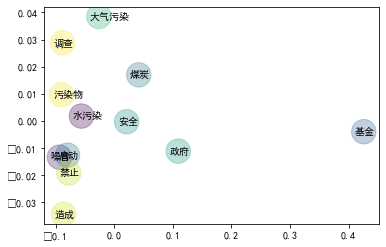

In [140]:
corpus = ['大气污染','水污染','噪音','基金','安全','煤炭','启动','造成','污染物','禁止','调查','政府']  #选中的单词
vector = model.wv[corpus]   #嵌入词向量
vector_ = pca.fit_transform(vector)  #降维
y_ = KM.fit_predict(vector_)

colors=np.random.rand(len(corpus))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.scatter(vector_[:,0],vector_[:,1],c=colors,alpha=0.3,s=600)   #绘制散点图
for i in range(len(corpus)):    #给每个点进行中文标注
    plt.annotate(s=corpus[i], xy=(vector_[:, 0][i], vector_[:, 1][i]),
                 xytext=(vector_[:, 0][i]-0.015, vector_[:, 1][i]-0.001))
plt.show()

**可以看到“污染物”、“水污染”，“煤炭”之间的距离较近，“基金”与其他词距离较远，word2vec是可以有效提取到语义的**